In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycox torchtuples --quiet
!pip install torch --quiet
!pip install numpy pandas scikit-learn matplotlib seaborn lifelines pycox torchtuples --quiet
!pip install torch --quiet

In [2]:
# Step 2: Load dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torchtuples as tt
import torch.nn as nn
from pycox.models import CoxPH
from pycox.models import CoxPH
import shap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pycox.models import CoxPH
from sklearn.model_selection import train_test_split
from pycox.evaluation import EvalSurv
import scipy.integrate
import os
from lifelines import CoxPHFitter

data_path = '/content/drive/MyDrive/project/data/survival_dataset.csv'
df=pd.read_csv(data_path)
df.head()

,time,event,age,sex,bmi,bp,comorbidity,treatment
0,4.30,1,68,1,28.2,110,2,0
1,35.48,0,81,0,18.0,133,0,1
2,28.70,0,58,1,31.2,100,1,0
3,18.70,0,44,1,31.4,157,0,0
4,45.86,0,72,0,23.4,90,1,0


In [3]:
# Shape of dataset
print("Shape:", df.shape)
print("--------------------------")
# Info about columns and datatypes
df.info()
print("-----------------------------")
# Check for missing values
df.isnull().sum()

Shape: (1200, 8)
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         1200 non-null   float64
 1   event        1200 non-null   int64  
 2   age          1200 non-null   int64  
 3   sex          1200 non-null   int64  
 4   bmi          1200 non-null   float64
 5   bp           1200 non-null   int64  
 6   comorbidity  1200 non-null   int64  
 7   treatment    1200 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 75.1 KB
-----------------------------


,0
time,0
event,0
age,0
sex,0
bmi,0
bp,0
comorbidity,0
treatment,0


In [4]:
# Event count
event_counts = df['event'].value_counts()
event_counts
# Censoring rate
censoring_rate = (df['event'] == 0).mean()
print("Censoring Rate:", censoring_rate)

Censoring Rate: 0.73


In [5]:
df.describe()

,time,event,age,sex,bmi,bp,comorbidity,treatment
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,49.340708,0.270000,60.158333,0.482500,28.870167,134.684167,1.460833,0.501667
std,48.189032,0.444145,17.407780,0.499902,6.262695,25.528040,1.185877,0.500206
min,0.000000,0.000000,30.000000,0.000000,18.000000,90.000000,0.000000,0.000000
25%,15.137500,0.000000,46.000000,0.000000,23.375000,113.000000,1.000000,0.000000
50%,35.290000,0.000000,60.000000,0.000000,28.950000,135.500000,1.000000,1.000000
75%,65.970000,1.000000,76.000000,1.000000,34.300000,156.000000,2.000000,1.000000
max,302.370000,1.000000,89.000000,1.000000,39.900000,179.000000,6.000000,1.000000


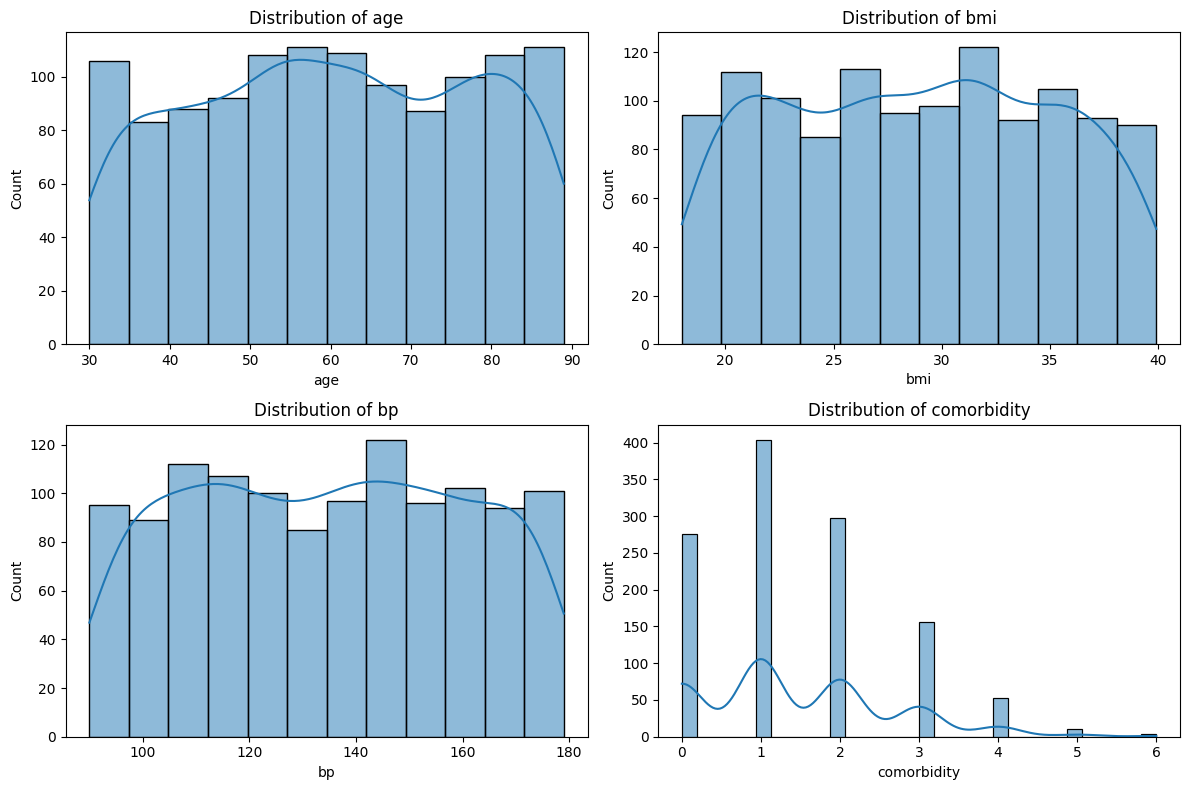

In [6]:
num_cols = ["age", "bmi", "bp", "comorbidity"]

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [7]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=fc5615457ad82ab8200c3ed997e57b1b20b70c0e28f96c8057a3473afb337e76
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


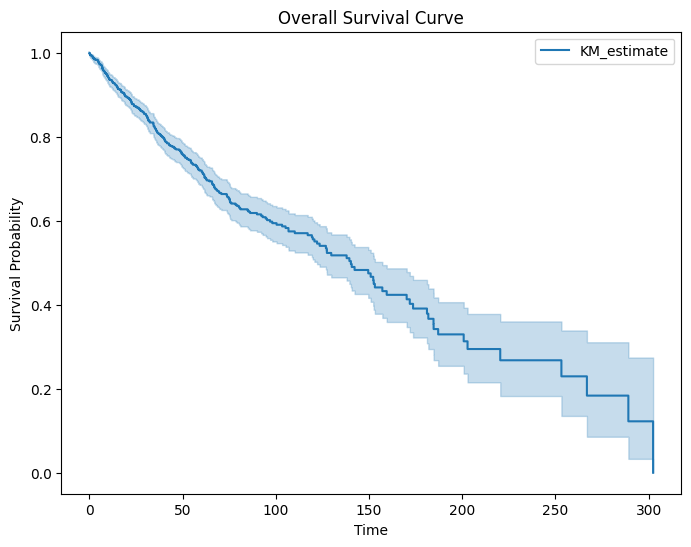

In [8]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
kmf.fit(durations=df['time'], event_observed=df['event'])
kmf.plot()
plt.title("Overall Survival Curve")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

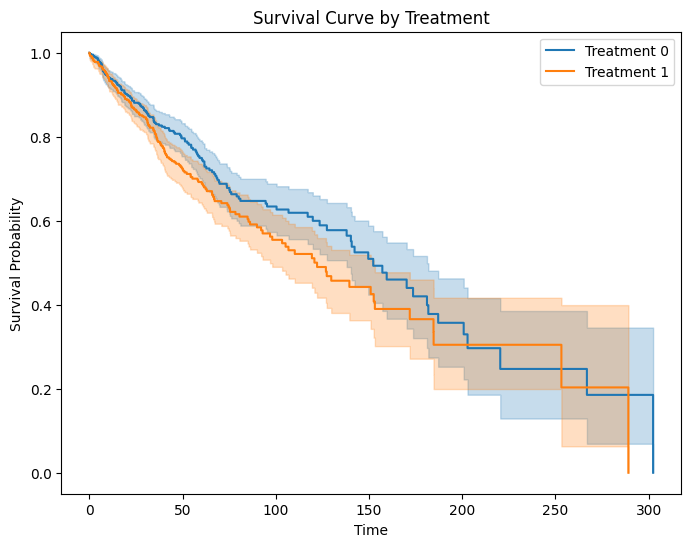

In [9]:
plt.figure(figsize=(8,6))

for group in df['treatment'].unique():
    kmf.fit(
        durations=df[df['treatment'] == group]['time'],
        event_observed=df[df['treatment'] == group]['event'],
        label=f"Treatment {group}"
    )
    kmf.plot()

plt.title("Survival Curve by Treatment")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

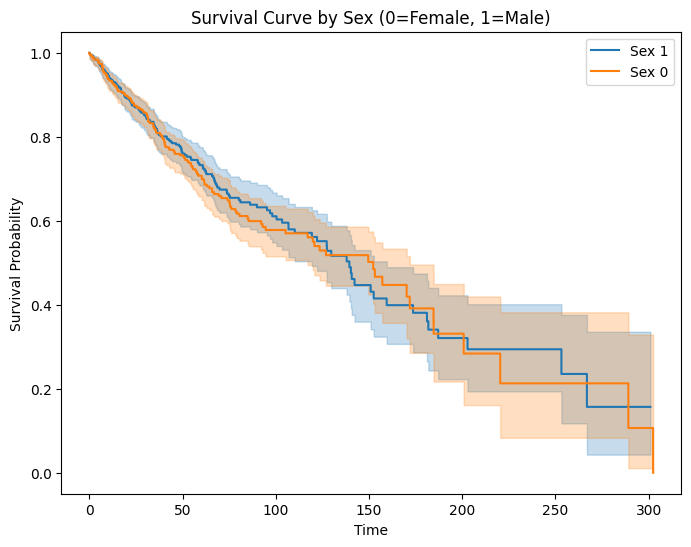

In [10]:
plt.figure(figsize=(8,6))

for group in df['sex'].unique():
    kmf.fit(
        durations=df[df['sex'] == group]['time'],
        event_observed=df[df['sex'] == group]['event'],
        label=f"Sex {group}"
    )
    kmf.plot()

plt.title("Survival Curve by Sex (0=Female, 1=Male)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

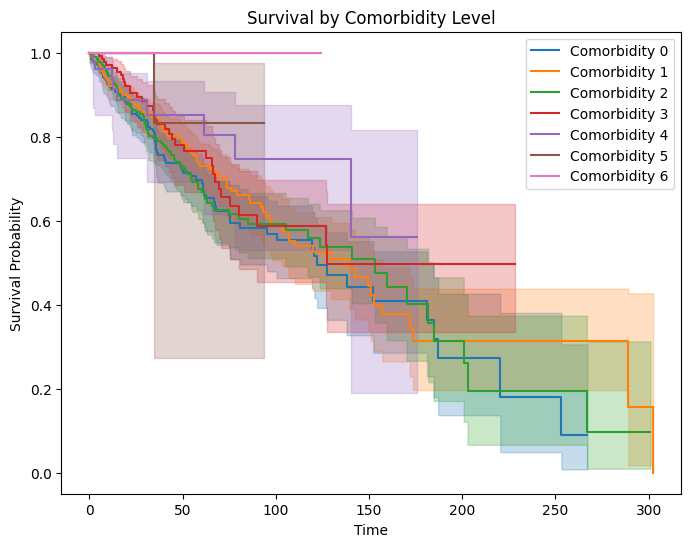

In [11]:
plt.figure(figsize=(8,6))

for com in sorted(df['comorbidity'].unique()):
    kmf.fit(
        durations=df[df['comorbidity'] == com]['time'],
        event_observed=df[df['comorbidity'] == com]['event'],
        label=f"Comorbidity {com}"
    )
    kmf.plot()

plt.title("Survival by Comorbidity Level")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

In [14]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [12]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")

df.head()

,time,event,age,sex,bmi,bp,comorbidity,treatment
0,4.30,1,68,1,28.2,110,2,0
1,35.48,0,81,0,18.0,133,0,1
2,28.70,0,58,1,31.2,100,1,0
3,18.70,0,44,1,31.4,157,0,0
4,45.86,0,72,0,23.4,90,1,0


In [15]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, test_df.shape

((960, 8), (240, 8))

In [16]:
cph = CoxPHFitter()

cph.fit(
    train_df,
    duration_col="time",
    event_col="event"
)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 960 total observations, 707 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 960
number of events observed = 253
   partial log-likelihood = -1492.65
         time fit was run = 2025-11-18 09:37:01 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age         -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
sex         -0.05      0.95      0.13           -0.30            0.20                0.74                1.22
bmi         -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
bp           0.00      1.00      0.00           -0.00            0.01                1.00                1.01
comorbidity -0.11      0.89      0.06           -0.23           -0.00                0.80                1.00
treatment    0.24      1.28      0.13           -0.01            0.50                0.99                1.64

             cmp to     z    p  -log2(p)
covariate                               
age            0.00 -1.41 0.16      2.66
sex            0.00 -0.39 0.70      0.52
bmi            0.00 -0.06 0.96      0.07
bp             0.00  0.45 0.66      0.61
comorbidity    0.00 -2.02 0.04      4.53
treatment      0.00  1.91 0.06      4.17
---
Concordance = 0.56
Partial AIC = 2997.30
log-likelihood ratio test = 10.35 on 6 df
-log2(p) of ll-ratio test = 3.18

In [17]:
# Predict partial hazards for test data
test_pred = cph.predict_partial_hazard(test_df)

# C-index
c_index = concordance_index(
    test_df["time"],
    -test_pred,
    test_df["event"]
)

print("Test C-index:", c_index)

Test C-index: 0.546996556561663


In [18]:
cph.check_assumptions(train_df, p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [19]:
# Run in a notebook cell with a leading ! or in terminal
!pip install lifelines scikit-learn matplotlib joblib
# Optional (for ElasticNet Cox)
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.5
    Uninstalling osqp-1.0.5:
      Successfully uninstalled osqp-1.0.5


In [20]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import joblib
import os

# load
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")
train_df, test_df = df.sample(frac=0.8, random_state=42), df.drop(df.sample(frac=0.8, random_state=42).index)  # fallback if you didn't split earlier
# If you already have train_df/test_df from prior cell, comment the above two lines and keep those variables.
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

Train shape: (960, 8) Test shape: (240, 8)


In [21]:
def cv_penalizer_lifelines(df_train, penalizer_grid, n_splits=4, random_state=0):
    """
    Returns dict penalizer -> mean C-index (CV) using lifelines CoxPHFitter.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {}
    Xy = df_train.reset_index(drop=True)
    for pen in penalizer_grid:
        cidxs = []
        for train_idx, val_idx in kf.split(Xy):
            train = Xy.iloc[train_idx]
            val = Xy.iloc[val_idx]
            cph = CoxPHFitter(penalizer=pen)
            # fit
            cph.fit(train, duration_col="time", event_col="event", show_progress=False)
            preds = cph.predict_partial_hazard(val.drop(columns=["time", "event"]))
            cidx = concordance_index(val["time"], -preds, val["event"])
            cidxs.append(cidx)
        results[pen] = np.mean(cidxs)
        print(f"penalizer={pen:.5f} -> CV C-index={results[pen]:.4f}")
    return results

# Define grid and run CV
pen_grid = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
cv_results = cv_penalizer_lifelines(train_df, pen_grid, n_splits=4)
best_pen = max(cv_results, key=cv_results.get)
print("Best penalizer:", best_pen, "CV C-index:", cv_results[best_pen])

penalizer=0.00010 -> CV C-index=0.5339
penalizer=0.00100 -> CV C-index=0.5337
penalizer=0.01000 -> CV C-index=0.5336
penalizer=0.05000 -> CV C-index=0.5319
penalizer=0.10000 -> CV C-index=0.5313
penalizer=0.50000 -> CV C-index=0.5297
penalizer=1.00000 -> CV C-index=0.5286
penalizer=5.00000 -> CV C-index=0.5273
Best penalizer: 0.0001 CV C-index: 0.5339114208784853


In [22]:
os.makedirs("../results/model_checkpoints", exist_ok=True)

best_cph = CoxPHFitter(penalizer=best_pen)
best_cph.fit(train_df, duration_col="time", event_col="event")
best_cph.print_summary()

# Save model (joblib recommended for lifelines objects)
joblib.dump(best_cph, "../results/model_checkpoints/cox_lifelines_penalized.pkl")
print("Saved model to ../results/model_checkpoints/cox_lifelines_penalized.pkl")

<lifelines.CoxPHFitter: fitted with 960 total observations, 709 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 960
number of events observed = 251
   partial log-likelihood = -1456.82
         time fit was run = 2025-11-18 09:52:01 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age         -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
sex         -0.08      0.92      0.13           -0.33            0.17                0.72                1.19
bmi          0.01      1.01      0.01           -0.01            0.03                0.99                1.03
bp          -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
comorbidity -0.13      0.88      0.06           -0.24           -0.02                0.79                0.98
treatment    0.24      1.27      0.13           -0.01            0.49                0.99                1.64

             cmp to     z    p  -log2(p)
covariate                               
age            0.00 -1.54 0.12      3.03
sex            0.00 -0.63 0.53      0.92
bmi            0.00  0.60 0.55      0.87
bp             0.00 -0.56 0.58      0.79
comorbidity    0.00 -2.28 0.02      5.47
treatment      0.00  1.89 0.06      4.09
---
Concordance = 0.57
Partial AIC = 2925.63
log-likelihood ratio test = 11.00 on 6 df
-log2(p) of ll-ratio test = 3.50

Saved model to ../results/model_checkpoints/cox_lifelines_penalized.pkl


In [23]:
# load model if needed:
# best_cph = joblib.load("../results/model_checkpoints/cox_lifelines_penalized.pkl")

X_test = test_df.drop(columns=["time", "event"])
test_partial_hazard = best_cph.predict_partial_hazard(X_test)
test_cindex = concordance_index(test_df["time"], -test_partial_hazard, test_df["event"])
print("Test C-index (penalized Cox):", test_cindex)

# Attach predictions for inspection
test_df = test_df.copy()
test_df["partial_hazard"] = np.ravel(test_partial_hazard)
test_df.sort_values("partial_hazard", ascending=False).head(8)

Test C-index (penalized Cox): 0.5479267914383208


,time,event,age,sex,bmi,bp,comorbidity,treatment,partial_hazard
21,20.13,0,31,0,39.0,125,0,1,1.809527
337,6.57,0,36,0,27.7,91,0,1,1.723271
510,46.49,0,43,0,29.0,97,0,1,1.653870
1139,50.30,1,30,0,29.6,156,0,1,1.644011
600,32.51,0,45,0,32.8,130,0,1,1.595745
804,59.78,0,31,1,22.8,102,0,1,1.563705
995,2.03,1,33,0,32.5,107,1,1,1.552269
397,8.55,0,49,0,29.2,118,0,1,1.552028


,feature,coef_penalized,coef_unpenalized
5,treatment,0.241582,0.241690
4,comorbidity,-0.128075,-0.128136
1,sex,-0.080420,-0.080459
2,bmi,0.006086,0.006089
0,age,-0.005773,-0.005775
3,bp,-0.001435,-0.001436


<Figure size 800x500 with 0 Axes>

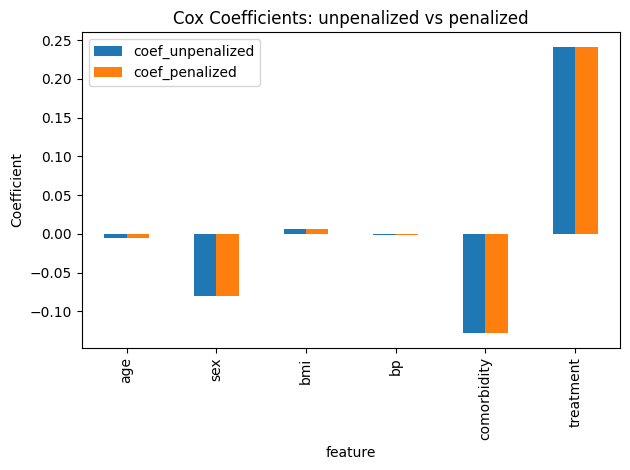

In [24]:
# Fit an unpenalized Cox for comparison (optional)
cph_unpen = CoxPHFitter(penalizer=0.0)
cph_unpen.fit(train_df, duration_col="time", event_col="event")
coef_df = pd.DataFrame({
    "feature": best_cph.params_.index,
    "coef_penalized": best_cph.params_.values,
    "coef_unpenalized": cph_unpen.params_.loc[best_cph.params_.index].values
}).reset_index(drop=True)

# show table
display(coef_df.sort_values("coef_penalized", key=abs, ascending=False).head(20))

# Plot coefficients
plt.figure(figsize=(8,5))
coef_df.set_index("feature")[["coef_unpenalized","coef_penalized"]].plot(kind="bar")
plt.title("Cox Coefficients: unpenalized vs penalized")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()

In [25]:


# 1 Make a clean copy of the dataframe (remove partial_hazard if it exists)
clean_df = df.drop(columns=['partial_hazard'], errors='ignore')

# 2 Instantiate ElasticNet Cox model
cph_en = CoxPHFitter(
    penalizer=0.1,    # controls overall regularization strength
    l1_ratio=0.5      # 0 = Ridge, 1 = LASSO, 0.5 = ElasticNet
)

# 3 Fit the model
cph_en.fit(clean_df, duration_col='time', event_col='event')

# 4 See results
cph_en.print_summary()

<lifelines.CoxPHFitter: fitted with 1200 total observations, 876 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 1200
number of events observed = 324
   partial log-likelihood = -1974.72
         time fit was run = 2025-11-18 09:53:21 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
sex         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
bmi          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
bp           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
comorbidity -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
treatment    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
age            0.00 -0.00 1.00      0.00
sex            0.00 -0.00 1.00      0.00
bmi            0.00  0.00 1.00      0.00
bp             0.00  0.00 1.00      0.00
comorbidity    0.00 -0.00 1.00      0.00
treatment      0.00  0.00 1.00      0.00
---
Concordance = 0.57
Partial AIC = 3961.44
log-likelihood ratio test = -0.00 on 6 df
-log2(p) of ll-ratio test = -0.00

In [27]:
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")
df = df.drop(columns=['partial_hazard'], errors='ignore')

# Features and targets
feature_names = [c for c in df.columns if c not in ['time','event']]
X = df[feature_names].values.astype('float32')
times = df['time'].values.astype('float32')
events = df['event'].values.astype('int32')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp).astype('float32')

# Train/val/test split
X_train, X_temp, t_train, t_temp, e_train, e_temp = train_test_split(
    X_scaled, times, events, test_size=0.3, random_state=42, stratify=events
)
X_val, X_test, t_val, t_test, e_val, e_test = train_test_split(
    X_temp, t_temp, e_temp, test_size=0.5, random_state=42, stratify=e_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (840, 6) Val: (180, 6) Test: (180, 6)


In [28]:
# ============================================
# Cell 3 — Define & Train DeepSurv (fixed)
# ============================================

# Network architecture
in_features = X_train.shape[1]
num_nodes = [64, 32]
out_features = 1
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features,
                              batch_norm=True, dropout=0.1)

# CoxPH model
model = CoxPH(net, torch.optim.Adam)
model.optimizer.set_lr(1e-3)

# Fit model — IMPORTANT: pass (durations, events) as a tuple
log = model.fit(
    X_train,
    (t_train, e_train),   # <-- fixed here
    batch_size=32,
    epochs=100,
    val_data=(X_val, (t_val, e_val)),  # validation also as tuple
    verbose=True
)

# Compute baseline hazards
model.compute_baseline_hazards()

0:	[0s / 0s],		train_loss: 2.7823,	val_loss: 4.1418
1:	[0s / 0s],		train_loss: 2.6291,	val_loss: 4.0894
2:	[0s / 0s],		train_loss: 2.6145,	val_loss: 4.0722
3:	[0s / 0s],		train_loss: 2.5602,	val_loss: 4.0564
4:	[0s / 0s],		train_loss: 2.5707,	val_loss: 4.0527
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	
10:	[0s / 0s],	
11:	[0s / 1s],	
12:	[0s / 1s],	
13:	[0s / 1s],	
14:	[0s / 1s],	
15:	[0s / 1s],	
16:	[0s / 1s],	
17:	[0s / 1s],	
18:	[0s / 1s],	
19:	[0s / 1s],	
20:	[0s / 1s],	
21:	[0s / 1s],	
22:	[0s / 1s],	
23:	[0s / 1s],	
24:	[0s / 2s],	
25:	[0s / 2s],	
26:	[0s / 2s],	
27:	[0s / 2s],	
28:	[0s / 2s],	
29:	[0s / 2s],	
30:	[0s / 2s],	
31:	[0s / 2s],	
32:	[0s / 2s],	
33:	[0s / 2s],	
34:	[0s / 3s],	
35:	[0s / 3s],	
36:	[0s / 3s],	
37:	[0s / 3s],	
38:	[0s / 3s],	
39:	[0s / 3s],	
40:	[0s / 3s],	
41:	[0s / 3s],	
42:	[0s / 3s],	
43:	[0s / 4s],	
44:	[0s / 4s],	
45:	[0s / 4s],	
46:	[0s / 4s],	
47:	[0s / 4s],	
48:	[0s / 4s],	
49:	[0s / 4s],	
50:	[0s / 4s],	
51:	[0s /

,baseline_hazards
duration,
0.020000,0.0
0.030000,0.0
0.050000,inf
0.080000,inf
0.120000,inf
...,...
253.179993,inf
261.140015,0.0
266.859985,inf


In [29]:
# Patch for SciPy >=1.11
if not hasattr(scipy.integrate, "simps"):
    scipy.integrate.simps = scipy.integrate.simpson

# Predict survival curves for test set
surv = model.predict_surv_df(X_test)

# Evaluate
ev = EvalSurv(surv, t_test, e_test, censor_surv='km')
print("Test C-index:", ev.concordance_td())
print("Integrated Brier Score:", ev.integrated_brier_score(np.linspace(t_test.min(), t_test.max(), 100)))

Test C-index: 0.0
Integrated Brier Score: nan


In [30]:
# ============================================
# ✅ DeepSurv Training + Survival Prediction
# ============================================

# 1) Load and clean data
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")
df = df.drop(columns=['partial_hazard'], errors='ignore')

# 2) Prepare features and targets
feature_names = [c for c in df.columns if c not in ['time','event']]
X = df[feature_names].values.astype('float32')
t = df['time'].values.astype('float32') + 1e-3  # avoid zero durations
e = df['event'].values.astype('int32')

# 3) Impute and scale
X = SimpleImputer(strategy='mean').fit_transform(X)
X = StandardScaler().fit_transform(X).astype('float32')

# 4) Split
X_train, X_test, t_train, t_test, e_train, e_test = train_test_split(
    X, t, e, test_size=0.2, random_state=42, stratify=e
)

# 5) Define model
net = tt.practical.MLPVanilla(X_train.shape[1], [64, 32], 1, batch_norm=True, dropout=0.1)
model = CoxPH(net, torch.optim.Adam)
model.optimizer.set_lr(1e-3)

# 6) Train
model.fit(X_train, (t_train, e_train), batch_size=32, epochs=100, verbose=True)

# 7) Compute baseline hazards
model.compute_baseline_hazards()

# 8) Predict survival curves
surv = model.predict_surv_df(X_test[:20].astype('float32'))

# 9) Check values
print("Survival curves shape:", surv.shape)
print("Any NaNs?", surv.isna().any().any())
print("Max:", surv.max().max(), "Min:", surv.min().min())

# Save trained DeepSurv model
model.save_model_weights("/content/drive/MyDrive/project/deepsurv_model.pt")

0:	[0s / 0s],		train_loss: 2.6151
1:	[0s / 0s],		train_loss: 2.5353
2:	[0s / 0s],		train_loss: 2.5499
3:	[0s / 0s],		train_loss: 2.5478
4:	[0s / 0s],		train_loss: 2.5448
5:	[0s / 0s],		train_loss: 2.4965
6:	[0s / 0s],		train_loss: 2.4610
7:	[0s / 0s],		train_loss: 2.4986
8:	[0s / 0s],		train_loss: 2.5271
9:	[0s / 0s],		train_loss: 2.5010
10:	[0s / 0s],		train_loss: 2.5039
11:	[0s / 0s],		train_loss: 2.5418
12:	[0s / 1s],		train_loss: 2.4972
13:	[0s / 1s],		train_loss: 2.4978
14:	[0s / 1s],		train_loss: 2.5278
15:	[0s / 1s],		train_loss: 2.4770
16:	[0s / 1s],		train_loss: 2.4783
17:	[0s / 2s],		train_loss: 2.4636
18:	[0s / 2s],		train_loss: 2.4665
19:	[0s / 2s],		train_loss: 2.5016
20:	[0s / 2s],		train_loss: 2.4645
21:	[0s / 2s],		train_loss: 2.4832
22:	[0s / 3s],		train_loss: 2.4605
23:	[0s / 3s],		train_loss: 2.5348
24:	[0s / 4s],		train_loss: 2.4844
25:	[0s / 4s],		train_loss: 2.4353
26:	[0s / 5s],		train_loss: 2.4409
27:	[0s / 5s],		train_loss: 2.4466
28:	[0s / 5s],		train_loss: 2.

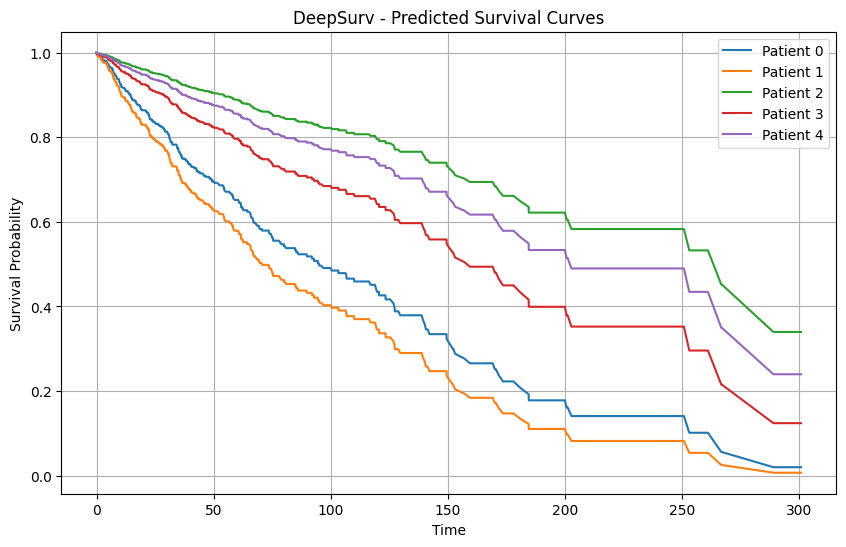

In [31]:
# ============================================
# ✅ Plot Survival Curves
# ============================================
import matplotlib.pyplot as plt

if not surv.isna().any().any():
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(surv.columns[:5]):
        plt.plot(surv.index, surv[col], label=f"Patient {i}")
    plt.title("DeepSurv - Predicted Survival Curves")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Still NaNs in survival curves. Check training loss and input scaling.")

  0%|          | 0/10 [00:00<?, ?it/s]

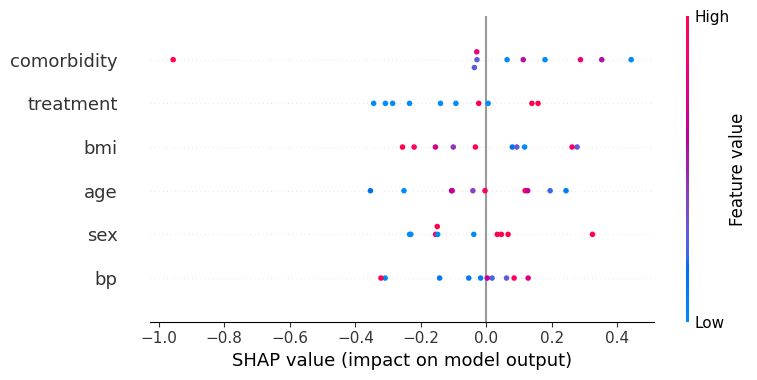

In [32]:
# ============================================
# Cell 6 — SHAP Analysis of DeepSurv Model
# ============================================

# 1) Prepare clean feature matrix (drop time/event)
feature_names = [c for c in df.columns if c not in ['time','event']]
X_raw = df[feature_names].values.astype('float32')

# 2) Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X_raw)

# 3) Scale features (same as training)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp).astype('float32')

# 4) Define SHAP-compatible prediction function
def risk_fn(x):
    x = np.asarray(x, dtype='float32')
    out = model.predict(x)  # log hazard ratio
    out = np.array(out).reshape(-1)
    if not np.isfinite(out).all():
        finite = out[np.isfinite(out)]
        med = np.median(finite) if finite.size > 0 else 0.0
        out = np.where(np.isfinite(out), out, med)
    return out

# 5) Select background and sample sets
background = X_scaled[:50]   # background for SHAP
sample = X_scaled[:10]       # samples to explain

# 6) Build KernelExplainer
explainer = shap.KernelExplainer(risk_fn, background)

# 7) Compute SHAP values
shap_values = explainer.shap_values(sample, nsamples=100)

# 8) Convert to array and fix shape
shap_arr = np.asarray(shap_values, dtype='float32')
if shap_arr.ndim == 1:
    shap_arr = shap_arr.reshape(1, -1)

# 9) Plot global SHAP summary
shap.summary_plot(shap_arr, sample, feature_names=feature_names)

In [33]:
# Save trained model
model.save_model_weights("/content/drive/MyDrive/project/deepsurv_model.pt")

In [35]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")

# Features only (drop time/event)
feature_names = [c for c in df.columns if c not in ['time','event']]
X_raw = df[feature_names].values.astype('float32')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X_raw)

# Scale features (same as training)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp).astype('float32')

In [36]:
# Risk function: log hazard ratio from trained DeepSurv model
def risk_fn(x):
    x = np.asarray(x, dtype='float32')
    out = model.predict(x)  # DeepSurv linear predictor
    out = np.array(out).reshape(-1)
    if not np.isfinite(out).all():
        finite = out[np.isfinite(out)]
        med = np.median(finite) if finite.size > 0 else 0.0
        out = np.where(np.isfinite(out), out, med)
    return out

In [38]:
# Define the same network architecture used in training
in_features = X_scaled.shape[1]
net = tt.practical.MLPVanilla(in_features, [64, 32], 1, batch_norm=True, dropout=0.1)

# Recreate CoxPH model
model = CoxPH(net, torch.optim.Adam)
model.optimizer.set_lr(1e-3)

# Load trained weights
model.load_model_weights("/content/drive/MyDrive/project/deepsurv_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

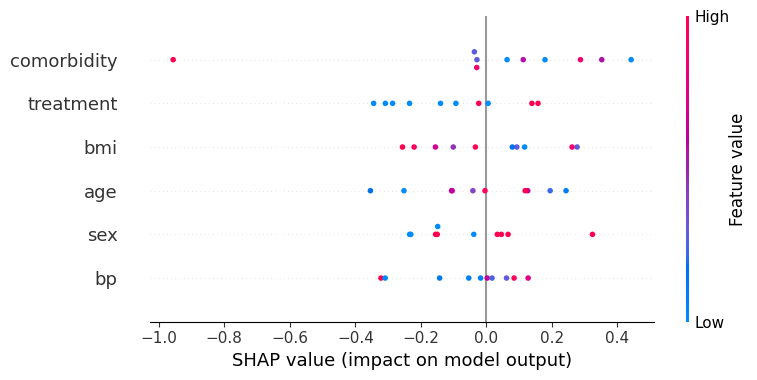

In [39]:
# Background and sample sets
background = X_scaled[:50]
sample = X_scaled[:10]

# KernelExplainer
explainer = shap.KernelExplainer(risk_fn, background)

# Compute SHAP values
shap_values = explainer.shap_values(sample, nsamples=100)

# Convert to array
shap_arr = np.asarray(shap_values, dtype='float32')
if shap_arr.ndim == 1:
    shap_arr = shap_arr.reshape(1, -1)

# Global summary plot
shap.summary_plot(shap_arr, sample, feature_names=feature_names)

Low-risk patients: [[0]
 [0]
 [0]]
High-risk patients: [[0]
 [0]
 [0]]


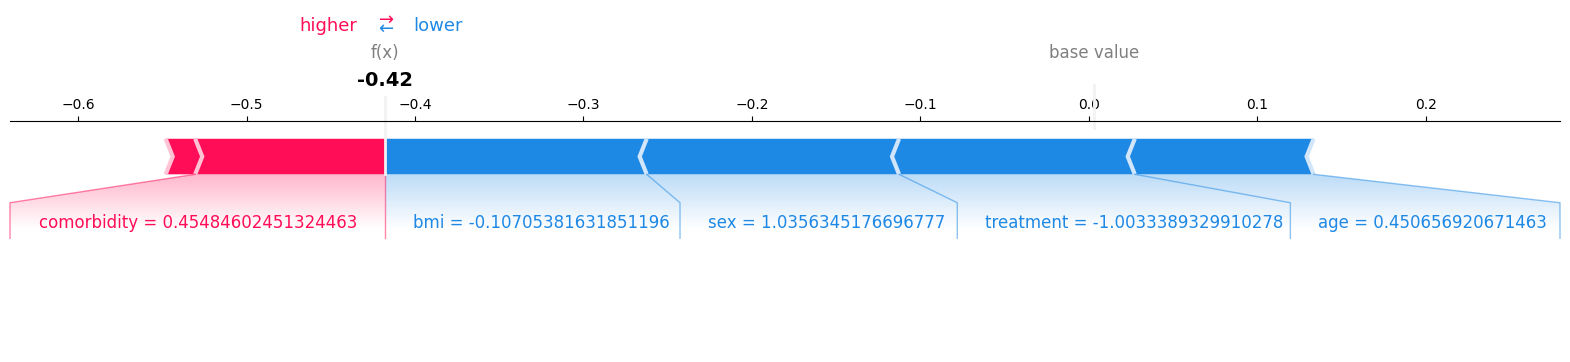

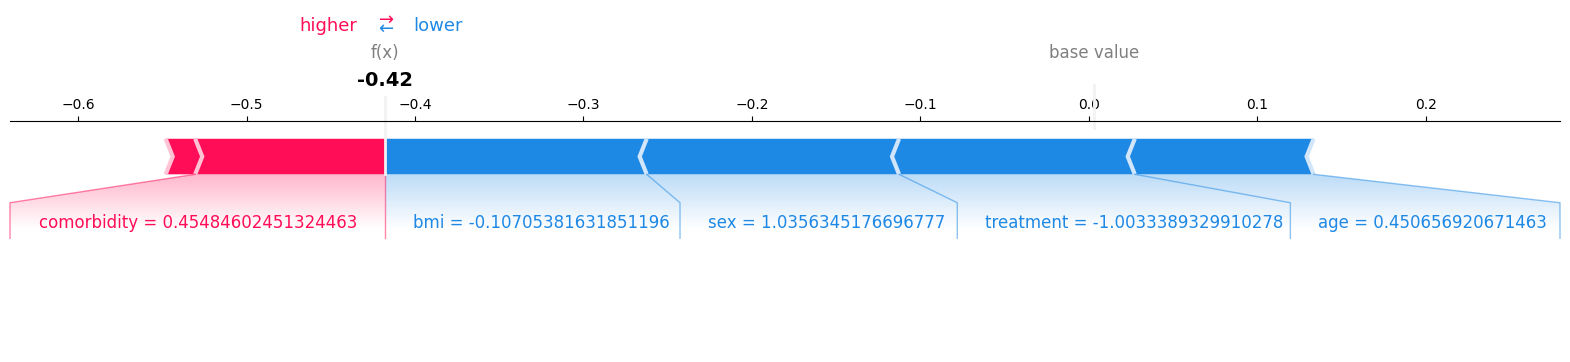

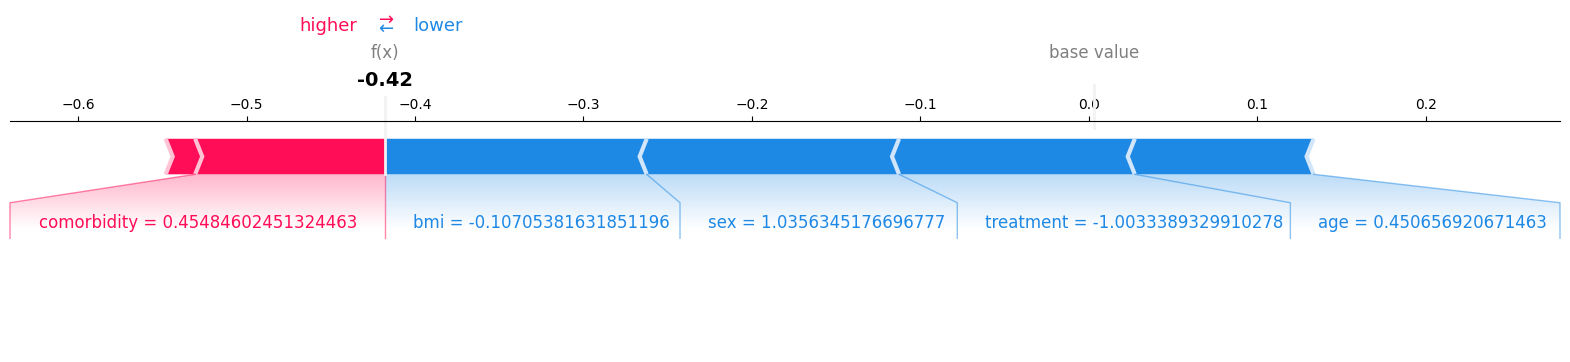

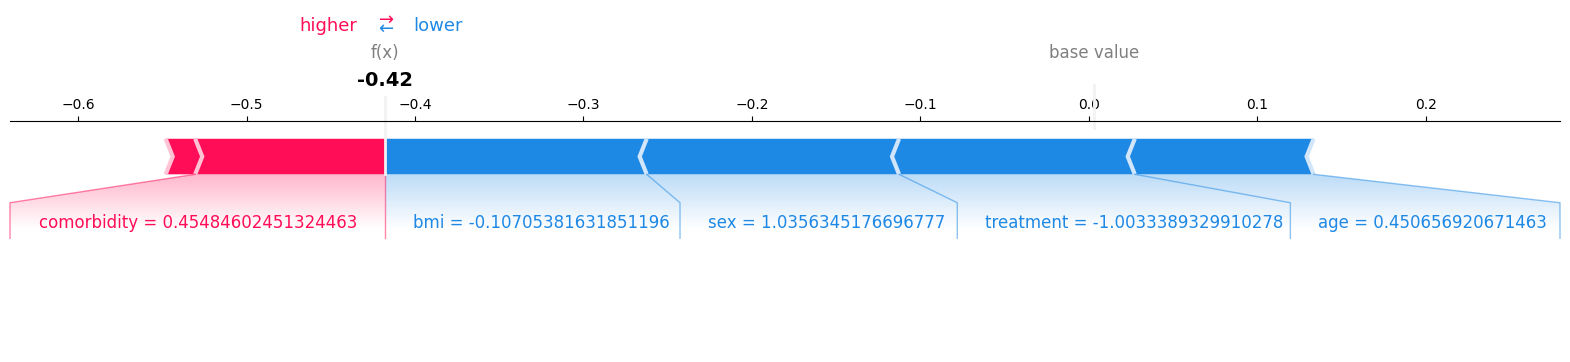

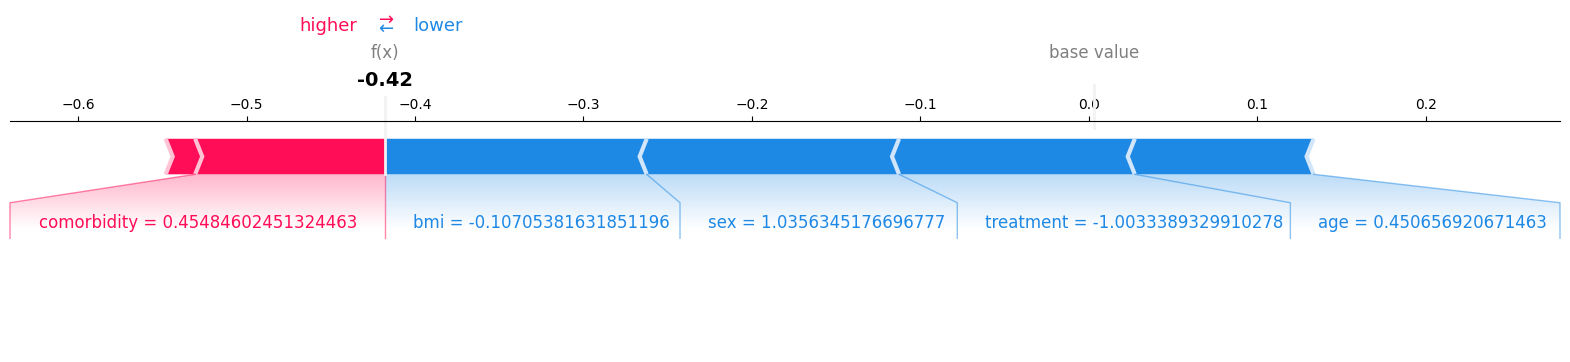

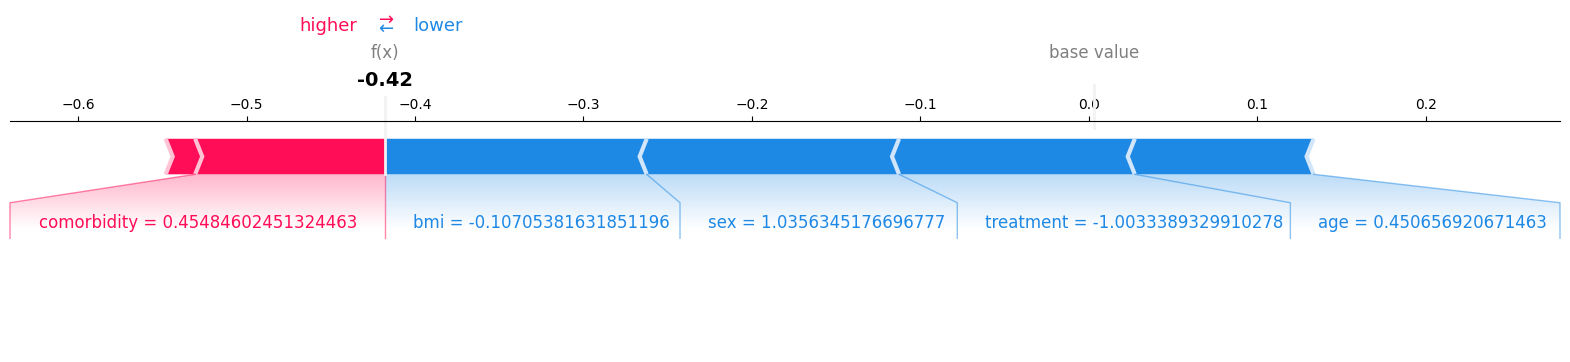

In [40]:
# ============================================
# Cell 5 — Local SHAP Force Plots
# ============================================

# 1) Compute risk scores for all patients
risk_scores = model.predict(X_scaled)

# 2) Sort patients by risk
sorted_idx = np.argsort(risk_scores)

# 3) Select 3 low-risk and 3 high-risk patients
low_risk_idx = sorted_idx[:3]
high_risk_idx = sorted_idx[-3:]

# 4) Generate force plots
print("Low-risk patients:", low_risk_idx)
print("High-risk patients:", high_risk_idx)

for idx in low_risk_idx:
    shap.force_plot(
        explainer.expected_value,
        shap_arr[idx],
        X_scaled[idx],
        feature_names=feature_names,
        matplotlib=True
    )

for idx in high_risk_idx:
    shap.force_plot(
        explainer.expected_value,
        shap_arr[idx],
        X_scaled[idx],
        feature_names=feature_names,
        matplotlib=True
    )

       Feature  CoxPH_Coefficient  MeanAbs_SHAP
4  comorbidity          -0.114585      0.248771
5    treatment           0.128302      0.173150
2          bmi           0.034840      0.159434
0          age          -0.121915      0.154421
1          sex          -0.026133      0.142629
3           bp           0.005973      0.113889


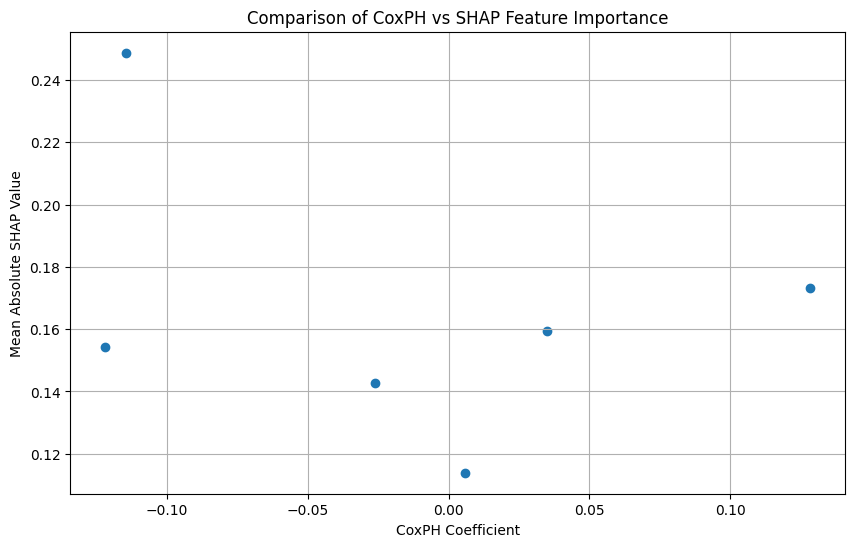

In [41]:
# ============================================
# Cell 6 — Compare SHAP Importance with CoxPH Coefficients (fixed)
# ============================================


# 1) Define a simple linear network for CoxPH
in_features = X_scaled.shape[1]
net_cox = nn.Sequential(nn.Linear(in_features, 1))  # plain linear layer

# 2) Fit CoxPH model
cox_model = CoxPH(net_cox, torch.optim.Adam)
cox_model.optimizer.set_lr(1e-3)

cox_model.fit(
    X_scaled,
    (df['time'].values.astype('float32'), df['event'].values.astype('int32')),
    batch_size=32,
    epochs=50,
    verbose=False
)

# 3) Extract CoxPH coefficients
weights = net_cox[0].weight.detach().numpy().flatten()

# 4) Compute mean absolute SHAP values (global importance)
shap_importance = np.abs(shap_arr).mean(axis=0)

# 5) Compare rankings
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'CoxPH_Coefficient': weights,
    'MeanAbs_SHAP': shap_importance
}).sort_values('MeanAbs_SHAP', ascending=False)

print(importance_df.head(10))  # top 10 features

# 6) Plot comparison
plt.figure(figsize=(10,6))
plt.scatter(importance_df['CoxPH_Coefficient'], importance_df['MeanAbs_SHAP'])
plt.xlabel("CoxPH Coefficient")
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Comparison of CoxPH vs SHAP Feature Importance")
plt.grid(True)
plt.show()